In [6]:
from pandas import read_csv, DataFrame
from numpy import maximum, minimum, zeros, diff, insert
from os import listdir
from os.path import join
from json import load
from scipy.integrate import trapezoid
from matplotlib.pyplot import plot, fill_between, axvline, legend, title, xlabel, ylabel, ylim
from itertools import product

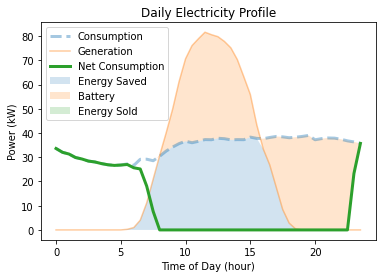

In [18]:
class Battery:
    def __init__(self, total_capacity, initial_capacity, time_unit):
        self.total_capacity = total_capacity
        self.profile = [initial_capacity]
        self.profile_from_grid = [0]
        self.time_unit = time_unit

    def power2energy(self, power):
        energy = power * self.time_unit / 2
        return energy

    def energy2power(self, energy):
        power = energy * 2 / self.time_unit
        return power

    def current_capacity(self):
        return self.profile[-1]

    def charge(self, power, from_grid):
        if power < 0:
            print("error")
        energy = self.power2energy(power)
        actual_charge = min(self.total_capacity - self.current_capacity(), energy)
        new_capacity = self.current_capacity() + actual_charge
        self.profile.append(new_capacity)
        if from_grid:
            actual_power = self.energy2power(actual_charge)
            self.profile_from_grid.append(actual_power)
        else:
            self.profile_from_grid.append(0)

    def discharge(self, power):
        if power < 0:
            print("error")
        energy = self.power2energy(power)
        actual_discharge = min(self.current_capacity(), energy)
        actual_power = self.energy2power(actual_discharge)
        new_capacity = self.current_capacity() - actual_discharge
        self.profile.append(new_capacity)
        self.profile_from_grid.append(-actual_power)

    def on_peak_behavior(self, available_power):
        if available_power > 0:
            self.charge(available_power, False)
        else:
            self.discharge(-available_power)

    def off_peak_behavior(self):
        energy_to_charge = self.total_capacity - self.current_capacity()
        power_needed = self.energy2power(energy_to_charge)
        self.charge(power_needed, True)

    def get_charge_profile(self):
        energy_diff = diff(insert(self.profile, 0, self.profile[0]))
        charge_profile = self.energy2power(energy_diff)
        return charge_profile


class System:
    pv_system_folder = "PV Information"
    consumption_profile_folder = "Daily Consumption Profile"
    generation_profile_folder = "Daily Generation Profile"
    tariff_consumption_threshold = 150
    time_diff = 0.5 
    days_in_month = 365.25/12
    on_peak_period = [9, 22]

    def get_pv_system_info(self, system_name):
        for file in listdir(self.pv_system_folder):
            if system_name in file:
                with open(join(self.pv_system_folder, file), "r") as pv_system_info_file:
                    pv_system_info = load(pv_system_info_file)
                    return pv_system_info
        print(f"File {system_name} not found")

    def get_tariff_type(self):
        if self.tou:
            tariff_type = "1.3"
        elif self.monthly_consumption <= self.tariff_consumption_threshold:
            tariff_type = "1.1"
        else:
            tariff_type = "1.2"
        return tariff_type

    def calculate_consumption(self):
        for file in listdir(self.consumption_profile_folder):
            if self.tariff_type in file and "Unit" in file:
                consumption_profile_df = read_csv(join(self.consumption_profile_folder, file))
                break

        time = consumption_profile_df["time"]
        consumption_profile = consumption_profile_df["Consumption"] * self.monthly_consumption
        return time, consumption_profile

    def calculate_generation(self):
        for file in listdir(self.generation_profile_folder):
            if "Unit" in file:
                generation_profile_df = read_csv(join(self.generation_profile_folder, file))

        generation_profile = (
            generation_profile_df[self.egat_region] * self.monthly_solar_energy
        )
        return generation_profile

    def calculate_energy_saved(self):
        energy_saved_profile = minimum(self.df["Consumption"], self.df["Generation"])
        energy_saved = trapezoid(energy_saved_profile, self.df["time"])
        return energy_saved_profile, energy_saved

    def tou_behavior(self, battery_capacity):
        battery_obj = Battery(battery_capacity, battery_capacity, self.time_diff)

        for index, values in self.df.iterrows():
            if index == 0:
                continue
            if self.on_peak_period[0] < values["time"] <= self.on_peak_period[1]:
                available_power = values["Generation"] - values["Consumption"]
                battery_obj.on_peak_behavior(available_power)
            else:
                battery_obj.off_peak_behavior()
        return battery_obj

    def normal_behavior(self, battery_capacity):
        battery_obj = Battery(battery_capacity, 0, self.time_diff)
        for index, values in self.df.iterrows():
            if index == 0:
                continue
            available_power = values["Generation"] - values["Consumption"]
            if available_power >= 0:
                battery_obj.charge(available_power, False)
            else:
                battery_obj.discharge(-available_power)
        return battery_obj

    def calculate_battery(self):
        battery_capacity = self.battery * self.days_in_month

        if self.tou:
            battery_obj = self.tou_behavior(battery_capacity)
        else:
            battery_obj = self.normal_behavior(battery_capacity)
        return battery_obj.profile, battery_obj.profile_from_grid, battery_obj.get_charge_profile()

    def calculate_energy_sold(self):
        if self.fit:
            energy_sold_profile = maximum(0, self.df["Generation"] - self.df["Consumption"] - (self.df["Charge"] - self.df["Battery from grid"]))
        else:
            energy_sold_profile = zeros(self.df.shape[0])
        energy_sold = trapezoid(energy_sold_profile, self.df["time"])
        return energy_sold_profile, energy_sold

    def calculate_net_consumption(self):
        net_consumption_profile = self.df["Consumption"] + self.df["Battery from grid"] - self.df["Energy saved"]
        net_consumption = trapezoid(net_consumption_profile, self.df["time"])
        return net_consumption_profile, net_consumption

    def linear_equation(x, slope, x1, y1):
        return slope*(x-x1)+y1

    def unit_ramp_edge(x, slope, x1, y1, x2):
        y = System.linear_equation(x, slope, x1, y1)
        y2 = System.linear_equation(x2, slope, x1, y1)
        return min(max(y, y1), y2) 

    def energy2cost_1(energy):
        cost_table =  [[0, 2.3488],
                       [15, 2.9882],
                       [25, 3.2405],
                       [35, 3.6237],
                       [100, 3.7171],
                       [150, 4.2218],
                       [400, 4.4217]]
        service_charge = 8.19
        cost = service_charge
        for level in range(len(cost_table)):
            if level == len(cost_table)-1:
                cost += System.unit_ramp_edge(
                    energy,
                    cost_table[level][1],
                    cost_table[level][0],
                    0,
                    float("inf"),
                )
                break
            cost += System.unit_ramp_edge(
                energy,
                cost_table[level][1],
                cost_table[level][0],
                0,
                cost_table[level+1][0],
            )
        return cost

    def energy2cost_2(energy):
        cost_table = [
            [0, 3.2484],
            [150, 4.2218],
            [400, 4.4217],
        ]
        service_charge = 24.62
        cost = service_charge
        for level in range(len(cost_table)):
            if level == len(cost_table) - 1:
                cost += System.unit_ramp_edge(
                    energy,
                    cost_table[level][1],
                    cost_table[level][0],
                    0,
                    float("inf"),
                )
                break
            cost += System.unit_ramp_edge(
                energy,
                cost_table[level][1],
                cost_table[level][0],
                0,
                cost_table[level + 1][0],
            )
        return cost

    def energy2cost_3(consumption_profile, time_profile):
        on_peak_rate = 5.1135
        off_peak_rate = 2.6369
        service_charge = 24.62

        energy_off_peak = trapezoid(
            consumption_profile[: int(System.on_peak_period[0] / System.time_diff + 1)],
            time_profile[: int(System.on_peak_period[0] / System.time_diff + 1)],
        )
        energy_off_peak += trapezoid(
            consumption_profile[int(System.on_peak_period[1] / System.time_diff) :],
            time_profile[int(System.on_peak_period[1] / System.time_diff) :],
        )
        energy_on_peak = trapezoid(
            consumption_profile[
                int(System.on_peak_period[0] / System.time_diff) 
                : int(System.on_peak_period[1] / System.time_diff)
            ],
            time_profile[
                int(System.on_peak_period[0] / System.time_diff) 
                : int(System.on_peak_period[1] / System.time_diff)
            ],
        )

        cost = service_charge
        cost += energy_off_peak * off_peak_rate
        cost += energy_on_peak * on_peak_rate
        return cost

    def energy2cost(self, type):
        tariff_type = self.get_tariff_type()
        if type == "original":
            if tariff_type == "1.1":
                return System.energy2cost_1(self.monthly_consumption)
            if tariff_type == "1.2":
                return System.energy2cost_2(self.monthly_consumption)
            if tariff_type == "1.3":
                return System.energy2cost_3(self.df["Consumption"], self.df["time"])
        elif type == "net":  
            if tariff_type == "1.1":
                return System.energy2cost_1(self.net_consumption)
            if tariff_type == "1.2":
                return System.energy2cost_2(self.net_consumption)
            if tariff_type == "1.3":
                return  System.energy2cost_3(self.df["Net consumption"], self.df["time"])
        print("error")

    def __init__(self, input):
        self.location_name = input["location name"]
        self.capacity = input["capacity"]
        self.egat_region = input["egat region"]
        self.monthly_consumption = input["monthly consumption"]
        self.tou = input["tou"]
        self.fit = input["fit"]
        self.battery = input["battery"]
        self.battery_multiplier = (self.battery / self.capacity)

        system_name = f"{self.location_name}_{self.capacity}kW"
        pv_system = self.get_pv_system_info(system_name=system_name)
        self.location = pv_system["location"]
        self.mounting_method = pv_system["mounting method"]
        self.system_loss = pv_system["system loss"]
        self.monthly_solar_energy = pv_system["monthly solar energy"]

        self.tariff_type = self.get_tariff_type()
        time_profile, consumption_profile = self.calculate_consumption()
        self.df = DataFrame({"time": time_profile, "Consumption": consumption_profile})
        self.df["Generation"] = self.calculate_generation()
        self.df["Energy saved"], self.energy_saved = self.calculate_energy_saved()
        self.df["Battery"], self.df["Battery from grid"], self.df["Charge"] = self.calculate_battery()
        self.df["Energy sold"], self.energy_sold = self.calculate_energy_sold()
        self.df["Net consumption"], self.net_consumption = self.calculate_net_consumption()
        self.consumption_reduced = self.monthly_consumption - self.net_consumption

        self.original_cost = self.energy2cost("original")
        self.new_cost = self.energy2cost("net")
        self.cost_saved = self.original_cost - self.new_cost

    def to_dict(self):
        result = {"location name": self.location_name,
                  "capacity": self.capacity,
                  "egat region": self.egat_region,
                  "monthly consumption": self.monthly_consumption,
                  "tou": self.tou,
                  "fit": self.fit,
                  "battery multiplier": self.battery_multiplier,
                  "battery": self.battery,
                  "location": self.location,
                  "mounting method": self.mounting_method,
                  "system loss": self.system_loss,
                  "monthly solar energy": self.monthly_solar_energy,
                  "tariff type": self.tariff_type,
                  "energy saved": self.energy_saved,
                  "energy sold": self.energy_sold,
                  "net consumption": self.net_consumption,
                  "consumption reduced": self.consumption_reduced,
                  "original cost": self.original_cost,
                  "new cost": self.new_cost,
                  "cost saved": self.cost_saved
                  }
        return result

    def plot(self):
        line_opacity = 0.4
        area_opacity = 0.2

        plot(
            self.df["time"],
            self.df["Consumption"],
            label="Consumption",
            alpha=line_opacity,
            linewidth=3,
            linestyle="--",
        )

        plot(
            self.df["time"],
            self.df["Generation"],
            label="Generation",
            alpha=line_opacity,
        )

        plot(
            self.df["time"],
            self.df["Net consumption"],
            linewidth=3,
            label="Net Consumption",
        )

        fill_between(
            self.df["time"],
            self.df["Energy saved"],
            alpha=area_opacity,
            label="Energy Saved",
        )

        fill_between(
            self.df["time"],
            self.df["Charge"] + self.df["Consumption"],
            self.df["Consumption"],
            alpha=area_opacity,
            label="Battery",
        )

        fill_between(
            self.df["time"],
            self.df["Generation"] - self.df["Energy sold"],
            self.df["Generation"],
            alpha=area_opacity,
            label="Energy Sold",
        )

        if self.tou:
            axvline(self.on_peak_period[0], color="red", linestyle="--")
            axvline(self.on_peak_period[1], color="red", linestyle="--")

        legend()
        title("Daily Electricity Profile")
        ylabel("Power (kW)")
        xlabel("Time of Day (hour)")    

test_input = {
    "location name": "T3 Technology",
    "capacity": 5,
    "egat region": "Metropolitan",
    "monthly consumption": 805,
    "tou": False,
    "fit": 0,
    "battery": 5,
}
test = System(test_input)
test.plot()

In [66]:
System.energy2cost_2(1750)

7536.625000000001

# Calculation Explanation

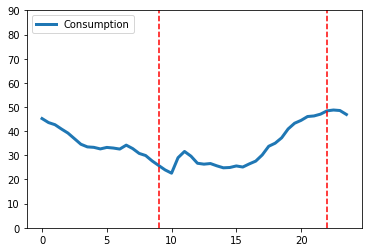

In [51]:
temp_input = {
    "location name": "T3 Technology",
    "capacity": 5,
    "egat region": "Metropolitan",
    "monthly consumption": 805,
    "tou": True,
    "fit": 0,
    "battery": 3,
}
temp = System(temp_input)
plot(
    temp.df["time"],
    temp.df["Consumption"],
    label="Consumption",
    linewidth=3,
)
legend()
ylim(0, 90)
if temp.tou:
    axvline(temp.on_peak_period[0], color="red", linestyle="--")
    axvline(temp.on_peak_period[1], color="red", linestyle="--")

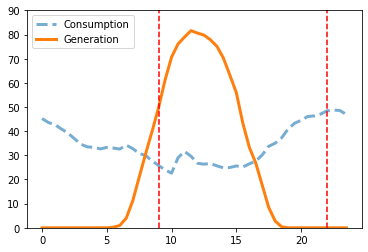

In [52]:
line_opacity = 0.4
area_opacity = 0.2
plot(
    temp.df["time"],
    temp.df["Consumption"],
    label="Consumption",
    alpha=0.6,
    linewidth=3,
    linestyle="--",
)

plot(
    temp.df["time"],
    temp.df["Generation"],
    label="Generation",
    # alpha=line_opacity,
    linewidth=3,
)
legend()
ylim(0, 90)
if temp.tou:
    axvline(temp.on_peak_period[0], color="red", linestyle="--")
    axvline(temp.on_peak_period[1], color="red", linestyle="--")

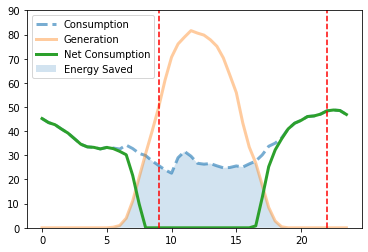

In [54]:
line_opacity = 0.4
area_opacity = 0.2
plot(
    temp.df["time"],
    temp.df["Consumption"],
    label="Consumption",
    alpha=0.6,
    linewidth=3,
    linestyle="--",
)

plot(
    temp.df["time"],
    temp.df["Generation"],
    label="Generation",
    alpha=line_opacity,
    linewidth=3,
)

plot(
    temp.df["time"],
    temp.df["Consumption"] - temp.df["Energy saved"],
    linewidth=3,
    label="Net Consumption",
)

fill_between(
    temp.df["time"],
    temp.df["Energy saved"],
    alpha=area_opacity,
    label="Energy Saved",
)

# fill_between(
#     temp.df["time"],
#     temp.df["Net consumption"],
#     alpha=area_opacity,
#     label="Net consumption",
#     color="g",
# )

legend()
ylim(0, 90)
if temp.tou:
    axvline(temp.on_peak_period[0], color="red", linestyle="--")
    axvline(temp.on_peak_period[1], color="red", linestyle="--")

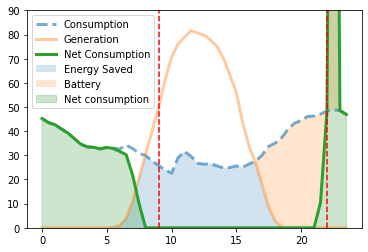

In [47]:
line_opacity = 0.4
area_opacity = 0.2
plot(
    temp.df["time"],
    temp.df["Consumption"],
    label="Consumption",
    alpha=0.6,
    linewidth=3,
    linestyle="--",
)

plot(
    temp.df["time"],
    temp.df["Generation"],
    label="Generation",
    alpha=line_opacity,
    linewidth=3,
)

plot(
    temp.df["time"],
    temp.df["Net consumption"],
    linewidth=3,
    label="Net Consumption",
)

fill_between(
    temp.df["time"],
    temp.df["Energy saved"],
    alpha=area_opacity,
    label="Energy Saved",
)

fill_between(
    temp.df["time"],
    temp.df["Charge"] + temp.df["Consumption"],
    temp.df["Consumption"],
    alpha=area_opacity,
    label="Battery",
)

fill_between(
    temp.df["time"],
    temp.df["Net consumption"],
    alpha=area_opacity,
    label="Net consumption",
    color="g",
)
legend()
ylim(0, 90)
if temp.tou:
    axvline(temp.on_peak_period[0], color="red", linestyle="--")
    axvline(temp.on_peak_period[1], color="red", linestyle="--")

# Batch Calculation

In [15]:
location_name_list = ["T3 Technology"]
egat_region_list = ["Metropolitan"]
fit_list = [0]
capacity_list = [3.7, 5, 10]
battery_list = [0, 5.76, 8.64, 17.28]
# battery_multiplier_list = [0, 1, 2]
tou_list = [False, True]
monthly_consumption_list = range(250, 2000+1, 10)

configuration_list = []

keys = [
    "location name",
    "capacity",
    "egat region",
    "monthly consumption",
    "tou",
    "fit",
    "battery",
    # "battery_multiplier",
]

# Generate all possible combinations and convert them to a list of dictionaries
all_configurations = [
    dict(zip(keys, values))
    for values in product(
        location_name_list,
        capacity_list,
        egat_region_list,
        monthly_consumption_list,
        tou_list,
        fit_list,
        battery_list
        # battery_multiplier_list,
    )
]

all_systems = []
for configuration in all_configurations:
    # configuration["battery"] = configuration["capacity"] * configuration["battery_multiplier"]
    system = System(configuration)
    all_systems.append(system.to_dict())

system_df = DataFrame(all_systems)
system_df.to_csv("System Data")
system_df

,location name,capacity,egat region,monthly consumption,tou,fit,battery multiplier,battery,location,mounting method,system loss,monthly solar energy,tariff type,energy saved,energy sold,net consumption,consumption reduced,original cost,new cost,cost saved
0,T3 Technology,3.7,Metropolitan,250,False,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",building,14,429.88,1.2,122.574403,0.0,127.425597,122.574403,934.060000,438.549310,495.510690
1,T3 Technology,3.7,Metropolitan,250,False,0,1.556757,5.76,"[13.775369373556686, 100.59884245347287]",building,14,429.88,1.2,122.574403,0.0,58.516873,191.483127,934.060000,214.706212,719.353788
2,T3 Technology,3.7,Metropolitan,250,False,0,2.335135,8.64,"[13.775369373556686, 100.59884245347287]",building,14,429.88,1.2,122.574403,0.0,58.516873,191.483127,934.060000,214.706212,719.353788
3,T3 Technology,3.7,Metropolitan,250,False,0,4.670270,17.28,"[13.775369373556686, 100.59884245347287]",building,14,429.88,1.2,122.574403,0.0,58.516873,191.483127,934.060000,214.706212,719.353788
4,T3 Technology,3.7,Metropolitan,250,True,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",building,14,429.88,1.3,94.356033,0.0,155.643967,94.356033,968.237387,539.640938,428.596448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,T3 Technology,10.0,Metropolitan,2000,False,0,1.728000,17.28,"[13.775369373556686, 100.59884245347287]",building,14,1161.83,1.2,835.966719,0.0,838.170000,1161.830000,8642.050000,3504.786289,5137.263711
4220,T3 Technology,10.0,Metropolitan,2000,True,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",building,14,1161.83,1.3,649.056781,0.0,1350.943219,649.056781,7573.559094,4547.756217,3025.802877
4221,T3 Technology,10.0,Metropolitan,2000,True,0,0.576000,5.76,"[13.775369373556686, 100.59884245347287]",building,14,1161.83,1.3,649.056781,0.0,1350.943219,649.056781,7573.559094,3679.361193,3894.197901
4222,T3 Technology,10.0,Metropolitan,2000,True,0,0.864000,8.64,"[13.775369373556686, 100.59884245347287]",building,14,1161.83,1.3,649.056781,0.0,1350.943219,649.056781,7573.559094,3567.835813,4005.723281
